In [5]:
import numpy as np
import pandas as pd
from statsbombpy import sb
from mplsoccer import Pitch
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score
from matplotlib.colors import Normalize, LinearSegmentedColormap
from matplotlib import cm
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
pd.set_option('display.max_columns', None)

# Load Roboto font 
font_path = r"C:\Users\conno\Documents\Education\GIS\Applied Research Project\Roboto\static\Roboto-Regular.ttf"
roboto = fm.FontProperties(fname=font_path)
fm.fontManager.addfont(font_path)
roboto_name = roboto.get_name()

# Set style
plt.rcParams.update({
    'font.family': roboto_name,
    'font.size': 12,
    'axes.titlesize': 14,
    'axes.labelsize': 12,
    'xtick.labelsize': 10,
    'ytick.labelsize': 10,
    'legend.fontsize': 10,
    'axes.edgecolor': 'black',
    'axes.facecolor': '#F9F9F9',
    'grid.color': '#D3D3D3',
    'grid.linestyle': '--',
    'grid.linewidth': 1,
    'lines.linewidth': 2,
    'figure.figsize': (8, 5)
})


# ========= Load EURO24 StatsBomb 360 Data =========

competitions = sb.competitions()
competitions_24 = competitions[competitions['season_name'] == '2024']

# View all matches from EURO 2024
sb.matches(competition_id=55, season_id=282)

# Set path to local 360 data folder
three_sixty_path = 'C:/Users/conno/Documents/Education/GIS/Applied Research Project/open-data/data/three-sixty/'

# Load and filter all EURO 2024 matches
matches_df = sb.matches(competition_id=55, season_id=282)

# Create a datetime column for chronological sorting
matches_df['datetime'] = pd.to_datetime(matches_df['match_date'] + ' ' + matches_df['kick_off'])

# Keep only completed matches with 360 data
matches_df = matches_df[
    (matches_df['match_status'] == 'available') & 
    (~matches_df['last_updated_360'].isna())
]

# Sort by kickoff time
matches_df = matches_df.sort_values('datetime').reset_index(drop=True)

# Extract the match_id list in chronological order
match_ids = matches_df['match_id'].tolist()


# ========= Assign Pitch Zones =========

def assign_pitch_zones(df):
    def get_zone(x, y):
        if pd.isna(x) or pd.isna(y):
            return None

        # Defensive third
        if 0 <= x < 40:
            if 18 <= y <= 62:
                return 'Defensive central'
            else:
                return 'Defensive wide'

        # Middle third
        elif 40 <= x < 80:
            if 18 <= y <= 62:
                return 'Midfield central'
            else:
                return 'Midfield wide'

        # Attacking third
        elif 80 <= x <= 120:
            if 30 <= y <= 50 and 80 <= x < 102:
                return 'Attacking central low'
            elif y > 62 or y < 18:
                return 'Attacking wide'
            elif (18 <= y < 30) or (50 < y <= 62):
                return 'Half space'
            elif 30 <= y <= 50 and x >= 102:
                return 'Attacking central high'

        return None

    df['end_zone'] = df.apply(
        lambda row: get_zone(row['pass_end_x_aligned'], row['pass_end_y']), axis=1
    )

# Assign the pass start and end 1/3 zones 
def assign_pitch_thirds(df):
    def get_third(x):
        if pd.isna(x):
            return None
        elif x < 40:
            return 'Defensive Third'
        elif x < 80:
            return 'Middle Third'
        else:
            return 'Attacking Third'

    # Start third from event location
    df['start_third'] = df['location_x_aligned'].apply(get_third)

    # End third from pass end 
    df['end_third'] = df['pass_end_x_aligned'].apply(get_third)


# ========= Summary Dataframe =========

def generate_team_summary(df, match_id):
    team_rows = []
    teams = df['team_name'].dropna().unique()

    for team in teams:
        try:
            team_df = df[df['team_name'] == team]
            opponent = [t for t in teams if t != team][0]
            total_minutes = team_df['minute'].max()
            
            # Goals scored
            goals_scored = team_df[
                (team_df['type'] == 'Shot') &
                (team_df['shot_outcome'] == 'Goal')
            ].shape[0]
            goals_per_90 = round((goals_scored / total_minutes) * 90, 2)
            
            # Goals conceded
            opponent_df = df[df['team_name'] == opponent]
            goals_conceded = opponent_df[
                (opponent_df['type'] == 'Shot') &
                (opponent_df['shot_outcome'] == 'Goal')
            ].shape[0]
            goals_conceded_per_90 = round((goals_conceded / total_minutes) * 90, 2)

            # xG 
            xg_sum = team_df['shot_statsbomb_xg'].dropna().sum()
            xg_per_90 = round((xg_sum / total_minutes) * 90, 2)
            
            # xGA 
            xga_sum = opponent_df['shot_statsbomb_xg'].dropna().sum()
            xga_per_90 = round((xga_sum / total_minutes) * 90, 2)

            if pd.isna(total_minutes) or total_minutes == 0:
                raise ValueError("Invalid total minutes")

            # Carries 
            carries = team_df[team_df['type'] == 'Carry'].shape[0]
            carries_per_90 = round((carries / total_minutes) * 90, 2)

            # Counterattacks
            counter_possessions = team_df[
                (team_df['play_pattern'] == 'From Counter') &
                (team_df['possession'].notna())
            ]['possession'].nunique()
            counterattacks_per_90 = round((counter_possessions / total_minutes) * 90, 2)

            # Passes
            pass_df = team_df[team_df['type'] == 'Pass'].copy()
            team_passes = pass_df.shape[0]

            # Pass zone proportions 
            zone_counts = pass_df['end_zone'].value_counts(normalize=True).to_dict()
            all_zones = [
                'Defensive central',
                'Defensive wide',
                'Midfield central',
                'Midfield wide',
                'Attacking central low',
                'Attacking central high',
                'Attacking wide',
                'Half space',
                'None'
            ]
            zone_metrics = {
                f'zone_pct_{zone.lower().replace(" ", "_")}': round(zone_counts.get(zone, 0) * 100, 2)
                for zone in all_zones
            }

            # Median pass length by third
            median_lengths = pass_df.groupby('start_third')['pass_length'].median().to_dict()
            median_def = round(median_lengths.get('Defensive Third', 0), 2)
            median_mid = round(median_lengths.get('Middle Third', 0), 2)
            median_att = round(median_lengths.get('Attacking Third', 0), 2)

            # Pass direction 
            forward_passes = pass_df[
                (pass_df['pass_angle'].notna()) &
                (pass_df['pass_angle'] >= -0.79) & 
                (pass_df['pass_angle'] <= 0.79)
            ].shape[0]
            sideways_passes = pass_df[
                (pass_df['pass_angle'].notna()) &
                (((pass_df['pass_angle'] > 0.79) & (pass_df['pass_angle'] <= 2.36)) |
                 ((pass_df['pass_angle'] < -0.79) & (pass_df['pass_angle'] >= -2.36)))
            ].shape[0]
            backward_passes = pass_df[
                (pass_df['pass_angle'].notna()) &
                ((pass_df['pass_angle'] > 2.36) | (pass_df['pass_angle'] < -2.36))
            ].shape[0]

            forward_pct = round((forward_passes / team_passes) * 100, 2) if team_passes > 0 else 0
            sideways_pct = round((sideways_passes / team_passes) * 100, 2) if team_passes > 0 else 0
            backward_pct = round((backward_passes / team_passes) * 100, 2) if team_passes > 0 else 0

            # Summary metrics
            total_passes_in_match = df[df['type'] == 'Pass'].shape[0]
            passes_per_90 = round((team_passes / total_minutes) * 90, 2)
            possession_pct = round((team_passes / total_passes_in_match) * 100, 2) if total_passes_in_match > 0 else 0
            successful_passes = pass_df['pass_outcome'].isna().sum()
            pass_accuracy_pct = round((successful_passes / team_passes) * 100, 2) if team_passes > 0 else 0
            aerial_passes = pass_df[pass_df['pass_height'] == 'High Pass'].shape[0]
            aerial_pass_pct = round((aerial_passes / team_passes) * 100, 2) if team_passes > 0 else 0

            # Out-of-possession events 
            oop_event_types = [
                '50/50', 'Block', 'Clearance', 'Dribbled Past', 'Duel',
                'Foul Committed', 'Interception', 'Pressure'
            ]
            oop_events = team_df[team_df['type'].isin(oop_event_types)].shape[0]

            # Out-of-possession events with freeze_frame
            oop_ff_df = team_df[
                (team_df['type'].isin(oop_event_types)) &
                (team_df['freeze_frame'].notna())
            ].copy()
            
            # High Press (%) - Count defending players in attacking third
            def count_high_pressers(freeze, team_name):
                try:
                    return sum(
                        1 for player in freeze
                        if player.get('position', {}).get('name') != 'Goalkeeper'
                        and player.get('teammate') is True
                        and player.get('location') is not None
                        and player['location'][0] > 80  # Attacking third
                    )
                except Exception:
                    return 0
            
            oop_ff_df['high_press_count'] = oop_ff_df['freeze_frame'].apply(lambda ff: count_high_pressers(ff, team))
            
            # Keep events where at least 4 teammates are pressing in attacking third
            high_press_events = oop_ff_df[oop_ff_df['high_press_count'] >= 4].shape[0]
            
            # Calculate percentage
            high_press_pct = round((high_press_events / oop_events) * 100, 2) if oop_events > 0 else 0

            # Mid Block (%) — Count defending players in middle third
            oop_ff_df = team_df[
                (team_df['type'].isin(oop_event_types)) &
                (team_df['freeze_frame'].notna())
            ].copy()
            
            def count_mid_block_players(freeze_frame):
                try:
                    return sum(
                        1 for player in freeze_frame
                        if player.get('teammate') is True
                        and player.get('position', {}).get('name') != 'Goalkeeper'
                        and isinstance(player.get('location'), list)
                        and 40 <= player['location'][0] < 80
                    )
                except:
                    return 0
            
            oop_ff_df['mid_block_count'] = oop_ff_df['freeze_frame'].apply(count_mid_block_players)
            
            # Count how many events had 4 or more teammates in the middle third
            mid_block_events = oop_ff_df[oop_ff_df['mid_block_count'] >= 4].shape[0]
            
            # Mid block % of all out-of-possession events
            mid_block_pct = round((mid_block_events / oop_events) * 100, 2) if oop_events > 0 else 0

            # Low Block (%) — Count defending players in defensive third
            def count_low_block_players(freeze_frame):
                try:
                    return sum(
                        1 for player in freeze_frame
                        if player.get('teammate') is True
                        and player.get('position', {}).get('name') != 'Goalkeeper'
                        and isinstance(player.get('location'), list)
                        and 0 <= player['location'][0] < 40  # Defensive third
                    )
                except:
                    return 0
            
            oop_ff_df['low_block_count'] = oop_ff_df['freeze_frame'].apply(count_low_block_players)

            # Count how many events had 6 or more teammates in the defensive third
            low_block_events = oop_ff_df[oop_ff_df['low_block_count'] >= 6].shape[0]
            
            # Low block % of all out-of-possession events
            low_block_pct = round((low_block_events / oop_events) * 100, 2) if oop_events > 0 else 0
            
            # Counterpress events
            counterpress_events = team_df[
                (team_df['type'].isin(oop_event_types)) &
                (team_df['counterpress'] == True)
            ].shape[0]

            # Counterpress %
            counterpress_pct = round((counterpress_events / oop_events) * 100, 2) if oop_events > 0 else 0
            
            # Regroup % (defending opponent counterattacks) 
            # Get all out-of-possession possession IDs for the team
            oop_possession_ids = team_df[team_df['type'].isin(oop_event_types)]['possession'].dropna().unique()
            
            # Get the opponent's events with play_pattern == 'From Counter'
            opponent_counter_possessions = opponent_df[
                (opponent_df['play_pattern'] == 'From Counter') &
                (opponent_df['possession'].notna())
            ]['possession'].unique()
            
            # Find intersections of possession IDs
            regroup_possessions = np.intersect1d(oop_possession_ids, opponent_counter_possessions)
            
            # Count how many OOP events the team had in those possessions
            regroup_events = team_df[
                (team_df['type'].isin(oop_event_types)) &
                (team_df['possession'].isin(regroup_possessions))
            ].shape[0]
            
            # Calculate percentage
            regroup_pct = round((regroup_events / oop_events) * 100, 2) if oop_events > 0 else 0

            # Summary row
            team_rows.append({
                'match_id': match_id,
                'team': team,
                'opponent': opponent,
                'goals_per_90': goals_per_90,
                'xg_per_90': xg_per_90,
                'goals_conceded_per_90': goals_conceded_per_90,
                'xga_per_90': xga_per_90,
                'carries_per_90': carries_per_90,
                'counterattacks_per_90': counterattacks_per_90,
                'passes_per_90': passes_per_90,
                'possession_pct': possession_pct,
                'pass_accuracy_pct': pass_accuracy_pct,
                'aerial_pass_pct': aerial_pass_pct,
                'forward_pass_pct': forward_pct,
                'sideways_pass_pct': sideways_pct,
                'backward_pass_pct': backward_pct,
                'median_pass_length_def': median_def,
                'median_pass_length_mid': median_mid,
                'median_pass_length_att': median_att,
                'counterpress_pct': counterpress_pct,
                'regroup_pct': regroup_pct,
                'high_press_pct': high_press_pct,
                'mid_block_pct': mid_block_pct,
                'low_block_pct': low_block_pct,
                **zone_metrics
            })

            print(f"✅ Row added for {team} in match {match_id}")

        except Exception as e:
            print(f"⚠️ Error for {team} in match {match_id}: {e}")

    return pd.DataFrame(team_rows)


# ========= Loop Through Matches =========

all_team_summaries = []

for idx, match_id in enumerate(match_ids[:]):  # limit if testing
    print(f"\n📊 Processing match {match_id}...")

    try:
        # Load event and 360 data
        match_events_df = sb.events(match_id=match_id)
        match_360_df = pd.read_json(f'{three_sixty_path}{match_id}.json')

        # Print match info
        match_info = matches_df[matches_df['match_id'] == match_id].iloc[0]
        home_team = match_info['home_team']
        away_team = match_info['away_team']
        print(f"\"Match {idx + 1}: {home_team} v {away_team}\"")

        # Merge event and 360 data
        df = pd.merge(
            left=match_events_df,
            right=match_360_df,
            left_on='id',
            right_on='event_uuid',
            how='left'
        )
        print(f"✅ Merged event & 360 data → shape: {df.shape}")
        print(f"👉 Rows with 360 data: {df['visible_area'].notna().sum()}")

        # Assign team_name
        df['team_name'] = df['team']
        print("🏷️'team_name' assigned")

        # Filter event types
        relevant_event_types = [
            'Pass', 'Carry', 'Pressure', 'Duel', 'Shot', 'Ball Receipt',
            'Miscontrol', 'Dispossessed', '50/50', 'Block', 'Clearance',
            'Foul Committed', 'Interception', 'Dribbled Past'
        ]
        df = df[df['type'].isin(relevant_event_types)]
        print(f"🧹 Filtered relevant event types → shape: {df.shape}")

        # Count types
        type_counts = df['type'].value_counts().to_frame(name='count')
        type_counts.index.name = 'type'
        print("🔍 Events by type:")
        print(type_counts)

        # Build x/y coords
        df['location_x'] = df['location'].apply(lambda x: x[0] if isinstance(x, list) and len(x) == 2 else np.nan)
        df['location_y'] = df['location'].apply(lambda x: x[1] if isinstance(x, list) and len(x) == 2 else np.nan)
        df['pass_end_x'] = df['pass_end_location'].apply(lambda x: x[0] if isinstance(x, list) and len(x) == 2 else np.nan)
        df['pass_end_y'] = df['pass_end_location'].apply(lambda x: x[1] if isinstance(x, list) and len(x) == 2 else np.nan)

        # Assign pitch zones and thirds using standard coordinates
        df['location_x_aligned'] = df['location_x']
        df['pass_end_x_aligned'] = df['pass_end_x']
        
        assign_pitch_zones(df)
        assign_pitch_thirds(df)
        
        print("🗺️  Zones and thirds assigned (sample):")
        print(df[['team_name', 'type', 'end_zone', 'start_third', 'end_third']].dropna().head())

        team_summary_df = generate_team_summary(df, match_id)
        all_team_summaries.append(team_summary_df)
        print(f"📥 Added team summary for match {match_id}")

    except Exception as e:
        print(f"⚠️ Skipping match {match_id} due to error: {e}")

summary_df = pd.concat(all_team_summaries, ignore_index=True)
print("\n✅ Final summary dataframe (first 5 rows):")


📊 Processing match 3930158...
"Match 1: Germany v Scotland"
✅ Merged event & 360 data → shape: (3373, 94)
👉 Rows with 360 data: 3088
🏷️'team_name' assigned
🧹 Filtered relevant event types → shape: (2259, 95)
🔍 Events by type:
                count
type                 
Pass              999
Carry             773
Pressure          260
Duel               47
Block              35
Clearance          29
Miscontrol         25
Foul Committed     25
Shot               21
Dispossessed       14
Interception       12
Dribbled Past      11
50/50               8
🗺️  Zones and thirds assigned (sample):
   team_name  type               end_zone      start_third        end_third
6    Germany  Pass       Midfield central     Middle Third     Middle Third
7    Germany  Pass  Attacking central low     Middle Third  Attacking Third
8    Germany  Pass  Attacking central low  Attacking Third  Attacking Third
9   Scotland  Pass      Defensive central  Defensive Third  Defensive Third
10   Germany  Pass     

In [6]:
# ========= Team Averages =========

team_summary_avg = (
    summary_df
    .groupby('team', as_index=False)
    .mean(numeric_only=True)
    .round(2)  
)

display(team_summary_avg)

# ========= Standardise Data =========

from sklearn.preprocessing import StandardScaler

# drop columns
clean_summary = team_summary_avg.drop(columns=['match_id', 'goals_per_90', 'goals_conceded_per_90', 'xg_per_90', 'xga_per_90', 'zone_pct_none'])

# Standardise numeric features (excluding team column)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(clean_summary.drop(columns=['team']))

# Build final standardised DataFrame
team_summary_scaled = pd.DataFrame(X_scaled, columns=clean_summary.columns[1:])
team_summary_scaled['team'] = clean_summary['team']
display(team_summary_scaled)

,team,match_id,goals_per_90,xg_per_90,goals_conceded_per_90,xga_per_90,carries_per_90,counterattacks_per_90,passes_per_90,possession_pct,pass_accuracy_pct,aerial_pass_pct,forward_pass_pct,sideways_pass_pct,backward_pass_pct,median_pass_length_def,median_pass_length_mid,median_pass_length_att,counterpress_pct,regroup_pct,high_press_pct,mid_block_pct,low_block_pct,zone_pct_defensive_central,zone_pct_defensive_wide,zone_pct_midfield_central,zone_pct_midfield_wide,zone_pct_attacking_central_low,zone_pct_attacking_central_high,zone_pct_attacking_wide,zone_pct_half_space,zone_pct_none
0,Albania,3930169.00,0.93,0.68,1.27,1.34,306.24,2.51,373.01,35.37,80.88,20.94,34.85,49.55,15.61,18.42,16.41,13.76,16.26,1.62,13.79,27.99,43.64,16.70,11.13,23.94,27.87,2.91,3.08,10.02,4.35,0.0
1,Austria,3935002.00,1.43,1.45,1.18,1.34,392.23,4.72,488.43,52.70,81.39,17.87,30.11,53.57,16.32,18.83,16.98,14.17,15.07,2.54,19.58,40.77,26.06,13.94,5.45,27.70,19.07,4.12,5.15,16.21,8.35,0.0
2,Belgium,3935000.75,0.48,1.04,0.23,0.94,451.53,2.16,527.91,55.07,85.08,13.46,27.78,56.43,15.78,21.04,18.39,14.46,17.90,0.70,21.15,34.06,30.95,18.95,8.69,21.35,22.63,3.15,2.78,13.54,8.91,0.0
3,Croatia,3930168.33,0.61,1.82,1.88,1.21,468.21,1.23,553.70,55.74,87.02,12.76,24.53,58.51,16.96,18.66,15.48,12.54,18.92,2.19,20.02,44.35,25.32,13.21,6.06,29.02,21.40,4.33,3.34,14.14,8.51,0.0
4,Czech Republic,3932997.33,0.95,1.45,1.26,1.34,263.84,4.10,350.67,40.40,72.12,30.58,36.95,50.80,12.25,21.88,20.68,15.83,17.56,2.39,18.25,28.72,37.85,14.30,7.15,19.08,20.40,3.50,7.75,18.50,9.33,0.0
5,Denmark,3932874.50,0.48,0.93,0.96,1.12,450.45,2.40,566.99,53.91,84.14,15.55,28.20,56.16,15.64,19.33,15.30,14.16,18.83,2.69,17.26,40.70,28.13,10.83,6.36,33.08,22.21,3.30,4.04,12.21,7.97,0.0
6,England,3937088.71,1.51,1.23,1.07,1.07,478.25,1.79,569.82,54.89,86.16,14.37,26.18,57.74,16.08,21.90,16.58,14.05,20.53,2.04,19.20,34.59,31.32,14.69,5.79,27.93,23.18,2.83,3.00,14.06,8.53,0.0
7,France,3937516.83,0.91,1.71,0.83,1.08,438.31,3.14,522.44,50.95,87.22,11.61,27.61,56.23,16.16,18.95,16.24,14.10,16.71,1.48,17.80,33.65,33.21,13.11,5.65,22.79,23.83,3.28,4.19,17.93,9.23,0.0
8,Georgia,3939235.75,0.95,1.00,1.91,2.48,278.19,3.36,339.39,34.18,78.50,20.94,35.46,49.77,14.77,20.34,14.68,13.85,16.94,1.40,10.17,20.89,55.27,16.06,14.74,21.86,28.20,1.99,3.34,9.27,4.55,0.0
9,Germany,3934742.20,2.08,1.60,0.48,0.73,540.64,3.23,623.01,62.75,88.20,12.97,27.08,55.66,17.27,18.17,15.06,13.98,22.42,1.59,22.37,37.83,26.93,10.89,5.86,31.71,19.18,4.88,4.30,13.90,9.27,0.0


,carries_per_90,counterattacks_per_90,passes_per_90,possession_pct,pass_accuracy_pct,aerial_pass_pct,forward_pass_pct,sideways_pass_pct,backward_pass_pct,median_pass_length_def,median_pass_length_mid,median_pass_length_att,counterpress_pct,regroup_pct,high_press_pct,mid_block_pct,low_block_pct,zone_pct_defensive_central,zone_pct_defensive_wide,zone_pct_midfield_central,zone_pct_midfield_wide,zone_pct_attacking_central_low,zone_pct_attacking_central_high,zone_pct_attacking_wide,zone_pct_half_space,team
0,-0.829818,-0.045015,-1.028427,-1.546588,-0.265798,0.497088,1.006894,-1.176368,-0.079005,-0.952504,-0.112929,-0.681860,-0.748080,0.080605,-0.930719,-1.270852,1.303531,0.640178,1.263244,-0.304910,1.616050,0.027945,-0.836509,-1.696855,-2.263957,Albania
1,0.068397,2.295759,0.141080,0.447512,-0.161020,-0.033101,-0.154224,0.006745,0.459495,-0.718071,0.325955,-0.247307,-1.252809,1.236285,0.621522,1.249651,-1.184642,-0.340520,-1.117586,0.592223,-1.418893,1.559110,1.202636,0.851515,0.498019,Austria
2,0.687819,-0.415726,0.541115,0.720220,0.597082,-0.794707,-0.724984,0.848461,0.049931,0.545581,1.411616,0.060060,-0.052488,-1.075076,1.042423,-0.073712,-0.492539,1.439660,0.240493,-0.922881,-0.191121,0.331647,-1.132038,-0.247701,0.884696,Belgium
3,0.862051,-1.400757,0.802435,0.797314,0.995651,-0.915597,-1.521109,1.460619,0.944903,-0.815275,-0.829003,-1.974920,0.380137,0.796624,0.739482,1.955707,-1.289377,-0.599908,-0.861898,0.907174,-0.615323,1.824850,-0.580385,-0.000686,0.608498,Croatia
4,-1.272710,1.639071,-1.254789,-0.967804,-2.065519,2.161914,1.521313,-0.808485,-2.627399,1.025883,3.174852,1.512103,-0.196696,1.047859,0.264962,-1.126880,0.484047,-0.212603,-0.405014,-1.464501,-0.960203,0.774546,3.763882,1.794289,1.174703,Czech Republic
5,0.676538,-0.161524,0.937098,0.586743,0.403961,-0.433764,-0.622100,0.768999,-0.056252,-0.432177,-0.967598,-0.257905,0.341964,1.424711,-0.000447,1.235845,-0.891666,-1.445582,-0.736150,1.875886,-0.335970,0.521461,0.109181,-0.795251,0.235631,Denmark
6,0.966924,-0.807620,0.965773,0.699508,0.818966,-0.637550,-1.116922,1.234003,0.277467,1.037319,0.017966,-0.374493,1.063006,0.608198,0.519648,0.030816,-0.440172,-0.074026,-0.975071,0.647101,-0.001437,-0.073289,-0.915317,-0.033621,0.622308,England
7,0.549728,0.622265,0.485690,0.246146,1.036740,-1.114202,-0.766627,0.789600,0.338143,-0.649456,-0.243825,-0.321499,-0.557216,-0.095260,0.144322,-0.154573,-0.172672,-0.635440,-1.033754,-0.579299,0.222735,0.496152,0.256945,1.559625,1.105654,France
8,-1.122816,0.855283,-1.369085,-1.683517,-0.754763,0.497088,1.156320,-1.111620,-0.716104,0.145329,-1.444981,-0.586470,-0.459664,-0.195754,-1.901205,-2.671132,2.949574,0.412770,2.776412,-0.801196,1.729860,-1.136247,-0.580385,-2.005624,-2.125859,Georgia
9,1.618623,0.717590,1.504727,1.603929,1.238079,-0.879330,-0.896457,0.621845,1.180023,-1.095451,-1.152392,-0.448685,1.864634,0.042919,1.369493,0.669817,-1.061507,-1.424263,-0.945730,1.549005,-1.380957,2.520834,0.365306,-0.099492,1.133273,Germany


BIC suggests: 2 clusters
AIC suggests: 2 clusters


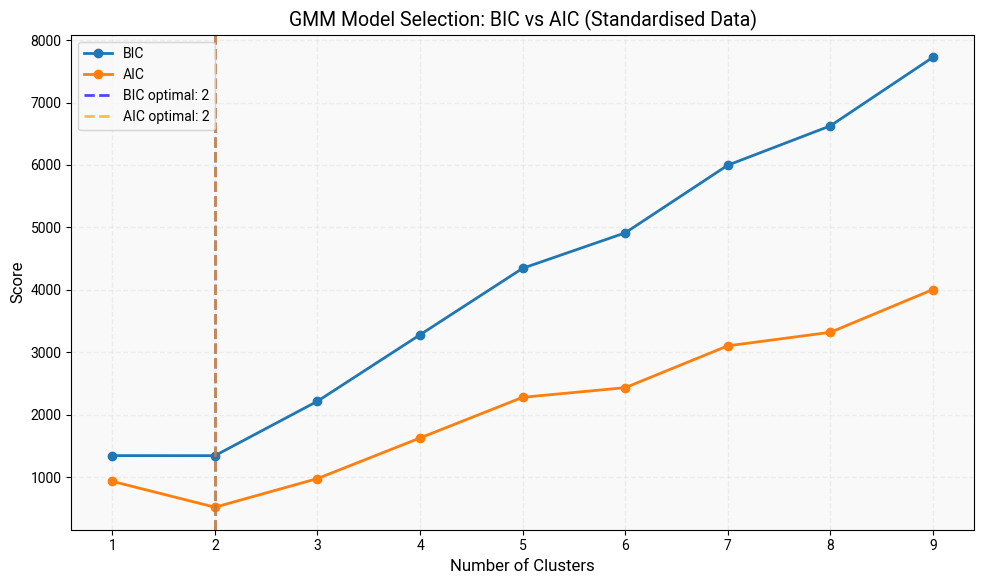

2 clusters: Silhouette = 0.325
3 clusters: Silhouette = 0.292
4 clusters: Silhouette = 0.229
5 clusters: Silhouette = 0.227
6 clusters: Silhouette = 0.075
Best silhouette score: 2 clusters (0.325)


In [12]:
X_standardized = X_scaled

# ========= BIC & AIC Tests =========

n_components_range = range(1, 10)  
bic_scores = []
aic_scores = []

for n in n_components_range:
    gmm = GaussianMixture(
        n_components=n, 
        covariance_type='full',  
        reg_covar=1e-3,         
        max_iter=200,
        random_state=42
    )
    gmm.fit(X_standardized)
    bic_scores.append(gmm.bic(X_standardized))
    aic_scores.append(gmm.aic(X_standardized))

# Find optimal cluster numbers
optimal_bic = n_components_range[np.argmin(bic_scores)]
optimal_aic = n_components_range[np.argmin(aic_scores)]
print(f"BIC suggests: {optimal_bic} clusters")
print(f"AIC suggests: {optimal_aic} clusters")

# Plot BIC/AIC
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(n_components_range, bic_scores, label='BIC', marker='o', linewidth=2)
ax.plot(n_components_range, aic_scores, label='AIC', marker='o', linewidth=2)
ax.axvline(x=optimal_bic, color='blue', linestyle='--', alpha=0.7, label=f'BIC optimal: {optimal_bic}')
ax.axvline(x=optimal_aic, color='orange', linestyle='--', alpha=0.7, label=f'AIC optimal: {optimal_aic}')
ax.set_xlabel('Number of Clusters')
ax.set_ylabel('Score')
ax.set_title('GMM Model Selection: BIC vs AIC (Standardised Data)')
ax.legend(frameon=True)
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig("gmm_bic_aic_standardised.png", dpi=300, bbox_inches='tight')
plt.show()


# ========= Silhouette Scores =========

silhouette_scores = []
cluster_range = range(2, 7)

for n_clusters in cluster_range:
    gmm = GaussianMixture(
        n_components=n_clusters,
        covariance_type='full',  # More stable than 'full'
        reg_covar=1e-3, 
        random_state=42
    )
    labels = gmm.fit_predict(X_standardized)
    silhouette_avg = silhouette_score(X_standardized, labels)
    silhouette_scores.append(silhouette_avg)
    print(f"{n_clusters} clusters: Silhouette = {silhouette_avg:.3f}")

best_silhouette_idx = np.argmax(silhouette_scores)
best_silhouette_k = cluster_range[best_silhouette_idx]
print(f"Best silhouette score: {best_silhouette_k} clusters ({max(silhouette_scores):.3f})")

In [8]:
# Test the 2-cluster solution for soft assignments
gmm_2_soft = GaussianMixture(n_components=2, covariance_type='full', reg_covar=1e-3, random_state=42)
gmm_2_soft.fit(X_standardized)
probs_2_soft = gmm_2_soft.predict_proba(X_standardized)

print("2-cluster probability analysis (standardized data):")
print(f"Min probability: {probs_2_soft.min():.6f}")
print(f"Max probability: {probs_2_soft.max():.6f}")
print(f"Hard assignments (prob > 0.99 or < 0.01): {np.sum((probs_2_soft > 0.99) | (probs_2_soft < 0.01))}/{probs_2_soft.size}")

2-cluster probability analysis (standardized data):
Min probability: 0.000000
Max probability: 1.000000
Hard assignments (prob > 0.99 or < 0.01): 48/48


In [9]:
# ========= Hierarchical GMM Clustering =========

def hierarchical_gmm_clustering(X, team_names):
    print("Stage 1: Creating 2 macro clusters...")
    
    # Create 2 macro clusters
    gmm_macro = GaussianMixture(
        n_components=2,
        covariance_type='full',
        reg_covar=1e-3,  
        random_state=42
    )
    macro_labels = gmm_macro.fit_predict(X)
    
    # Show macro clusters
    for cluster_id in range(2):
        teams_in_cluster = team_names[macro_labels == cluster_id]
        print(f"  Macro Cluster {cluster_id}: {teams_in_cluster.tolist()}")
    
    print("\nStage 2: Sub-clustering within macro clusters...")
    
    # Sub-cluster each macro cluster
    final_labels = np.copy(macro_labels)
    cluster_counter = 0
    cluster_info = {}
    
    for macro_id in range(2):
        cluster_mask = macro_labels == macro_id
        cluster_data = X[cluster_mask]
        cluster_teams = team_names[cluster_mask]
        
        print(f"\n  Processing Macro Cluster {macro_id} ({len(cluster_data)} teams)...")
        
        if len(cluster_data) < 4:
            print(f"    Too few teams - keeping as single micro-cluster")
            cluster_info[cluster_counter] = {
                'teams': cluster_teams.tolist(),
                'macro_parent': macro_id,
                'sub_clusters': 1
            }
            final_labels[cluster_mask] = cluster_counter
            cluster_counter += 1
            continue
        
        best_k = 2
        best_silhouette = -1
        
        for k in [2, 3]:
            if len(cluster_data) >= k:
                gmm_sub = GaussianMixture(
                    n_components=k,
                    covariance_type='full', 
                    reg_covar=1e-3,
                    random_state=42
                )
                sub_labels = gmm_sub.fit_predict(cluster_data)
                
                if len(np.unique(sub_labels)) > 1:
                    silhouette = silhouette_score(cluster_data, sub_labels)
                    print(f"    {k} sub-clusters: silhouette = {silhouette:.3f}")
                    if silhouette > best_silhouette:
                        best_silhouette = silhouette
                        best_k = k
        
        # Apply best sub-clustering
        gmm_sub = GaussianMixture(
            n_components=best_k,
            covariance_type='full', 
            reg_covar=1e-3,
            random_state=42
        )
        sub_labels = gmm_sub.fit_predict(cluster_data)
        
        print(f"    Selected {best_k} sub-clusters (silhouette: {best_silhouette:.3f})")
        
        # Assign final labels
        for sub_id in range(best_k):
            sub_mask = sub_labels == sub_id
            sub_teams = cluster_teams[sub_mask]
            
            cluster_info[cluster_counter] = {
                'teams': sub_teams.tolist(),
                'macro_parent': macro_id,
                'sub_clusters': best_k
            }
            
            # Update final labels
            original_indices = np.where(cluster_mask)[0]
            sub_indices = original_indices[sub_mask]
            final_labels[sub_indices] = cluster_counter
            
            print(f"      Micro-cluster {cluster_counter}: {sub_teams.tolist()}")
            cluster_counter += 1
    
    return final_labels, cluster_info

# Apply hierarchical clustering
team_names = team_summary_scaled['team'].values
hierarchical_labels, cluster_info = hierarchical_gmm_clustering(X_standardized, team_names)  
hierarchical_silhouette = silhouette_score(X_standardized, hierarchical_labels)  

print(f"\nHierarchical clustering result:")
print(f"Overall silhouette score: {hierarchical_silhouette:.3f}")

Stage 1: Creating 2 macro clusters...
  Macro Cluster 0: ['Austria', 'Belgium', 'Croatia', 'Denmark', 'England', 'France', 'Germany', 'Italy', 'Netherlands', 'Portugal', 'Serbia', 'Slovakia', 'Spain', 'Switzerland', 'Turkey', 'Ukraine']
  Macro Cluster 1: ['Albania', 'Czech Republic', 'Georgia', 'Hungary', 'Poland', 'Romania', 'Scotland', 'Slovenia']

Stage 2: Sub-clustering within macro clusters...

  Processing Macro Cluster 0 (16 teams)...
    2 sub-clusters: silhouette = 0.142
    3 sub-clusters: silhouette = 0.122
    Selected 2 sub-clusters (silhouette: 0.142)
      Micro-cluster 0: ['Austria', 'Croatia', 'Denmark', 'Germany', 'Italy', 'Spain']
      Micro-cluster 1: ['Belgium', 'England', 'France', 'Netherlands', 'Portugal', 'Serbia', 'Slovakia', 'Switzerland', 'Turkey', 'Ukraine']

  Processing Macro Cluster 1 (8 teams)...
    2 sub-clusters: silhouette = 0.211
    3 sub-clusters: silhouette = 0.169
    Selected 2 sub-clusters (silhouette: 0.211)
      Micro-cluster 2: ['Albani

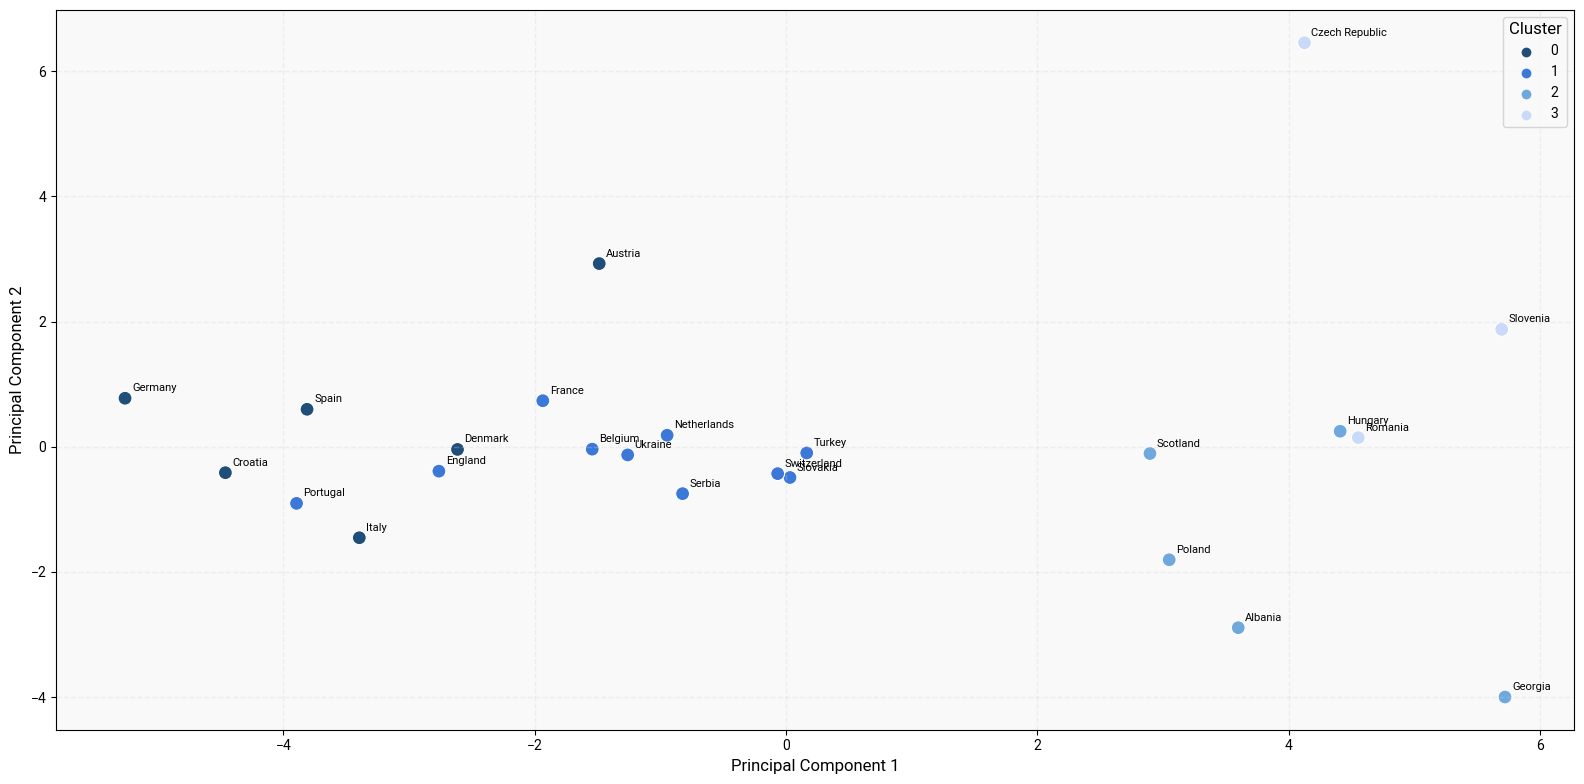

In [20]:
# ========= Visualise Clusters =========

# Create PCA representation for visualization purposes only
pca_vis = PCA(n_components=2)
X_pca_vis = pca_vis.fit_transform(X_standardized)
pca_df_vis = pd.DataFrame(X_pca_vis, columns=['PC1', 'PC2'])
pca_df_vis['team'] = team_summary_scaled['team']

# Hierarchical cluster plot
pca_hierarchical = pca_df_vis.copy()
pca_hierarchical['cluster'] = hierarchical_labels

palette_hierarchical = ['#1f4e79', '#3c78d8', '#6fa8dc', '#c9daf8', '#7f8c8d', '#2c3e50'][:n_final_clusters]

plt.figure(figsize=(16, 8))
sns.scatterplot(data=pca_hierarchical, x='PC1', y='PC2', hue='cluster', 
                palette=palette_hierarchical, s=100)

# Add team labels
for i, row in pca_hierarchical.iterrows():
    plt.annotate(row['team'], (row['PC1'], row['PC2']), 
                xytext=(5, 5), textcoords='offset points', fontsize=8)

plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Cluster')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig("hierarchical_clustering_new.png", dpi=300, bbox_inches='tight')
plt.show()

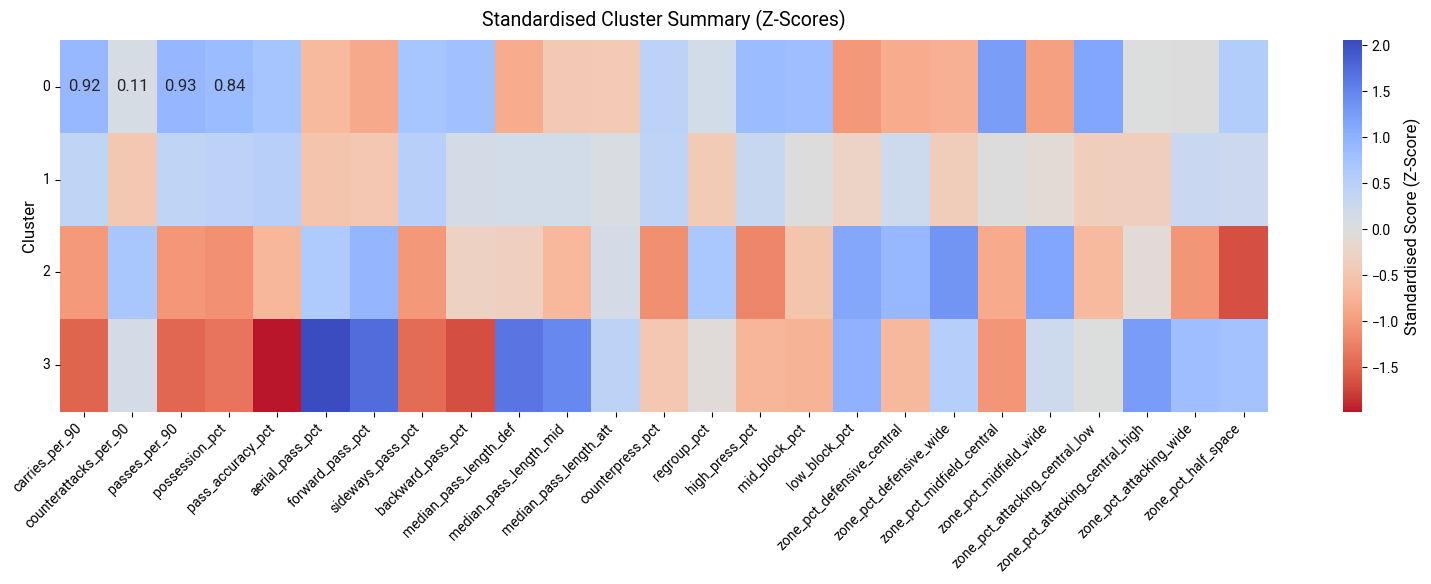

In [11]:
# ========= Sub-Cluster Feature Heatmap =========

# Create a dataframe with teams, cluster assignments, and standardised features
cluster_data = team_summary_scaled.copy()
cluster_data['cluster'] = hierarchical_labels

# Calculate cluster means for each feature 
feature_columns = [col for col in cluster_data.columns if col not in ['team', 'cluster']]
cluster_summary = cluster_data.groupby('cluster')[feature_columns].mean()

# Use the standardised features
cluster_summary_for_viz = cluster_summary.copy()

# Formatting
fig, ax = plt.subplots(figsize=(16, 6))
sns.heatmap(
    cluster_summary_for_viz,
    annot=True,                    
    cmap='coolwarm_r',            
    center=0,                      
    ax=ax,
    cbar_kws={'label': 'Standardised Score (Z-Score)'},       
    fmt='.2f'                     
)
ax.set_title('Standardised Cluster Summary (Z-Scores)', pad=10, fontsize=14)
ax.set_ylabel('Cluster', fontsize=12)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.yticks(rotation=0, fontsize=10)
plt.tight_layout()
plt.savefig("hierarchical_cluster_summary_heatmap_standardized.png", dpi=300, bbox_inches='tight')
plt.show()

C:\Users\conno\AppData\Local\Temp\ipykernel_2604\2241159773.py:24: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = truncate_colormap(cm.get_cmap('Reds'), minval=0.2, maxval=1.0)


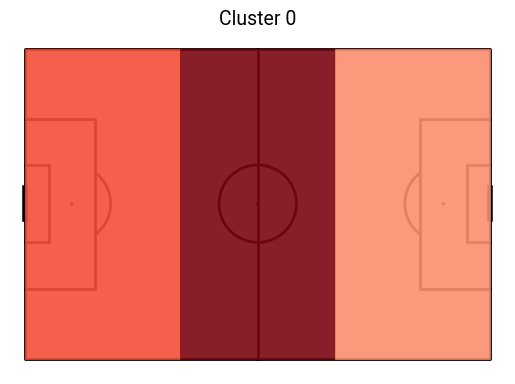

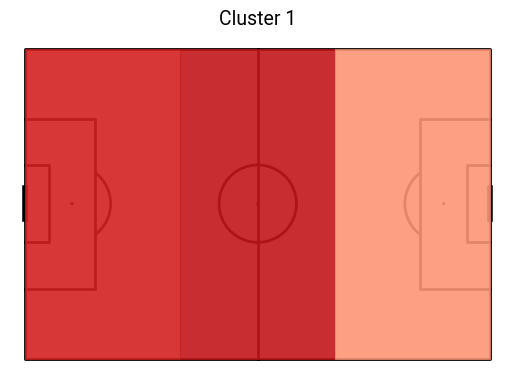

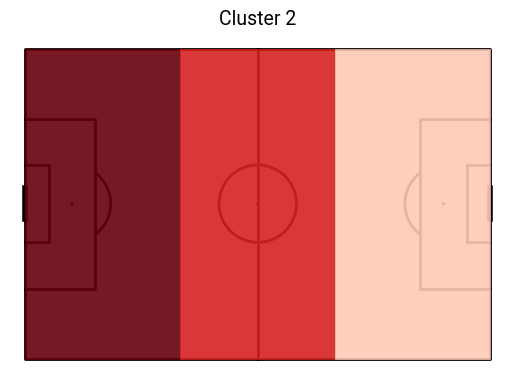

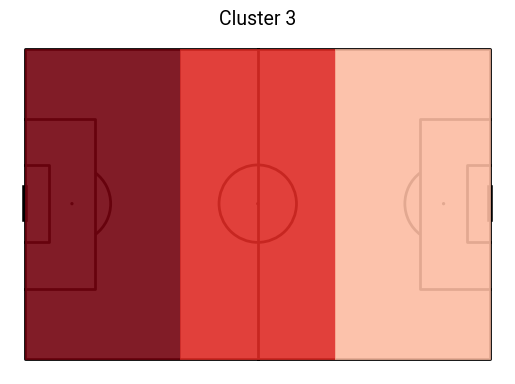

In [33]:
# ========= Sub-Cluster Out-of-Possession Heatmaps =========

# Truncate colormap
def truncate_colormap(cmap, minval=0.2, maxval=1.0, n=256):
    return LinearSegmentedColormap.from_list(
        f'trunc({cmap.name},{minval:.2f},{maxval:.2f})',
        cmap(np.linspace(minval, maxval, n))
    )

# Cluster summary data
data = {
    'cluster': [0, 1, 2, 3],
    'low_block_pct': [26.61, 31.94, 42.44, 41.45],
    'mid_block_pct': [40.91, 34.32, 31.82, 30.62],
    'high_press_pct': [19.81, 18.94, 12.79, 14.59],
}
df = pd.DataFrame(data)

# Normalise for consistent color scale
norm = Normalize(
    vmin=df[['low_block_pct', 'mid_block_pct', 'high_press_pct']].min().min(),
    vmax=df[['low_block_pct', 'mid_block_pct', 'high_press_pct']].max().max()
)
cmap = truncate_colormap(cm.get_cmap('Reds'), minval=0.2, maxval=1.0)

# Plot heatmap per cluster
for i, row in df.iterrows():
    fig, ax = plt.subplots(figsize=(6, 4))
    pitch = Pitch(pitch_color='white', line_color='black')
    pitch.draw(ax=ax)

    thirds = {
        'low_block_pct': (0, 0, 40, 80),
        'mid_block_pct': (40, 0, 40, 80),
        'high_press_pct': (80, 0, 40, 80)
    }

    for zone, (x, y, w, h) in thirds.items():
        value = row[zone]
        ax.add_patch(plt.Rectangle(
            (x, y), w, h,
            color=cmap(norm(value)),
            alpha=0.9,
            edgecolor='#bdbdbd',
            linewidth=0.5
        ))

    ax.set_title(f"Cluster {int(row['cluster'])}", fontsize=14)
    ax.axis('off')
    plt.tight_layout()
    plt.savefig(f"cluster_{int(row['cluster'])}_oop_heatmap.png", dpi=300, bbox_inches='tight')
    plt.show()

C:\Users\conno\AppData\Local\Temp\ipykernel_2604\2011004915.py:27: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = truncate_colormap(cm.get_cmap('Blues'), minval=0.2, maxval=1.0)


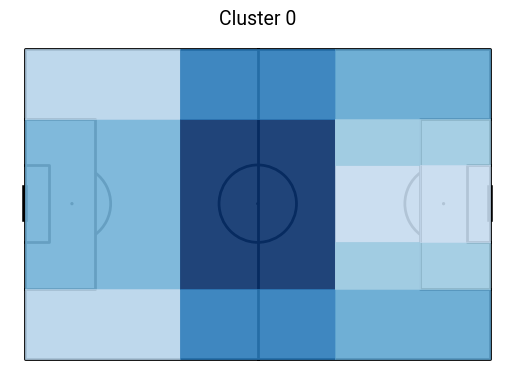

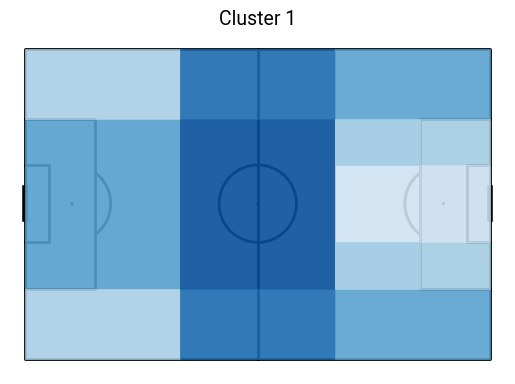

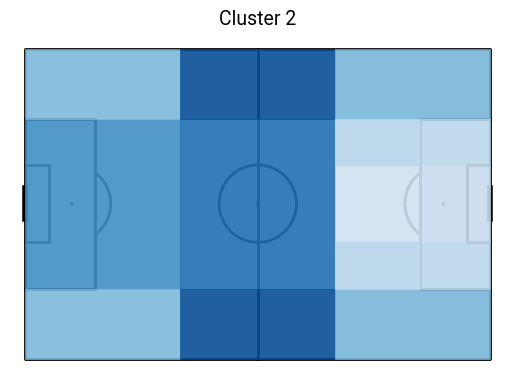

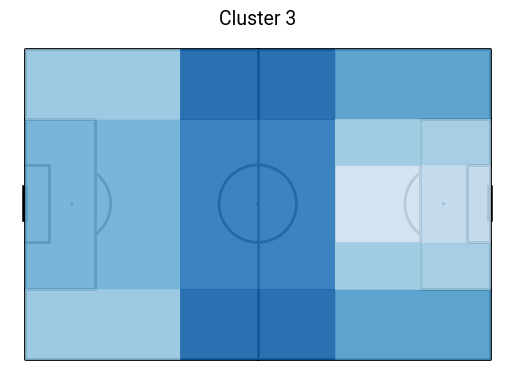

In [34]:
# ========= Sub-Cluster In-Possession Heatmaps =========

# Truncate colormap function
def truncate_colormap(cmap, minval=0.2, maxval=1.0, n=256):
    return LinearSegmentedColormap.from_list(
        f'trunc({cmap.name},{minval:.2f},{maxval:.2f})',
        cmap(np.linspace(minval, maxval, n))
    )

# Cluster zone data
data = {
    'cluster': [0, 1, 2, 3],
    'zone_1_pct_defensive_central': [12.22, 15.19, 17.47, 13.04],
    'zone_2_pct_defensive_wide': [5.93, 7.20, 11.31, 9.38],
    'zone_3_pct_midfield_central': [30.38, 26.09, 21.68, 20.75],
    'zone_4_pct_midfield_wide': [20.47, 22.53, 26.51, 23.88],
    'zone_5_pct_attacking_central_low': [4.16, 2.68, 2.37, 2.89],
    'zone_8_pct_attacking_central_high': [4.21, 3.54, 3.87, 5.20],
    'zone_6_pct_attacking_wide': [14.12, 14.72, 11.57, 16.14],
    'zone_7_pct_half_space': [8.53, 8.06, 5.24, 8.71]
}

df = pd.DataFrame(data)

zone_cols = [col for col in data if col != 'cluster']
norm = Normalize(vmin=df[zone_cols].min().min(), vmax=df[zone_cols].max().max())
cmap = truncate_colormap(cm.get_cmap('Blues'), minval=0.2, maxval=1.0)

# Define pitch zones as rectangles
zones = {
    'zone_1_pct_defensive_central': [(0, 18, 40, 44)],
    'zone_2_pct_defensive_wide': [(0, 0, 40, 18), (0, 62, 40, 18)],
    'zone_3_pct_midfield_central': [(40, 18, 40, 44)],
    'zone_4_pct_midfield_wide': [(40, 0, 40, 18), (40, 62, 40, 18)],
    'zone_5_pct_attacking_central_low': [(80, 18, 22, 44)],
    'zone_6_pct_attacking_wide': [(80, 0, 40, 18), (80, 62, 40, 18)],
    'zone_7_pct_half_space': [(80, 50, 40, 12), (80, 18, 40, 12)],
    'zone_8_pct_attacking_central_high': [(102, 30, 18, 20)]
}

# Plot heatmap for each cluster
for _, row in df.iterrows():
    fig, ax = plt.subplots(figsize=(6, 4))
    Pitch(pitch_color='white', line_color='black', pitch_length=120, pitch_width=80).draw(ax=ax)

    for zone_key, rects in zones.items():
        for x, y, w, h in rects:
            ax.add_patch(plt.Rectangle(
                (x, y), w, h,
                color=cmap(norm(row[zone_key])),
                alpha=0.9,
                edgecolor='#bdbdbd',
                linewidth=0.5
            ))

    ax.set_title(f"Cluster {int(row['cluster'])}", fontsize=14)
    ax.axis('off')
    plt.tight_layout()
    plt.savefig(f"cluster_{int(row['cluster'])}_ip_heatmap.png", dpi=300, bbox_inches='tight')
    plt.show()

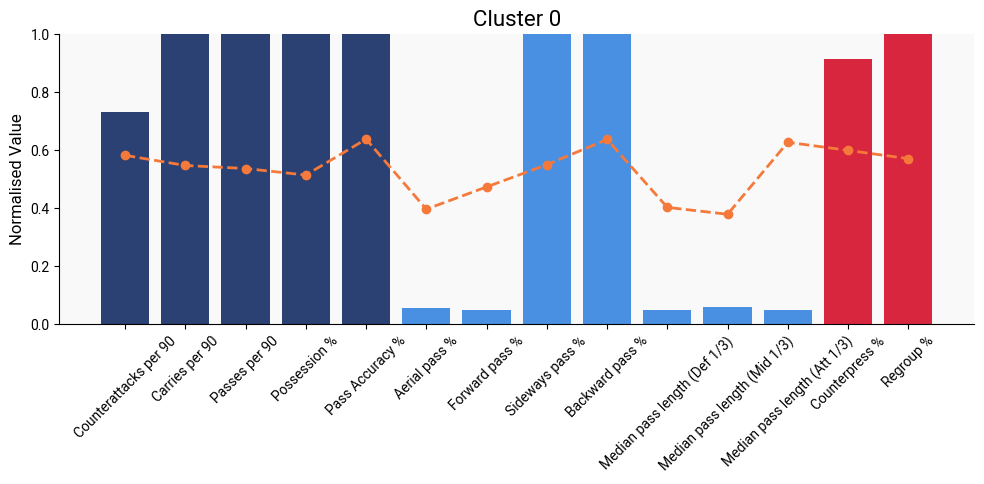

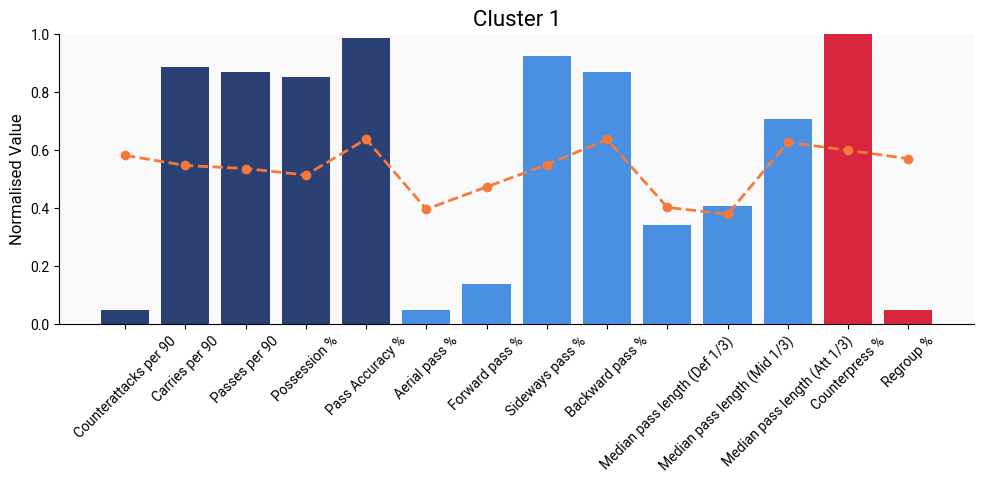

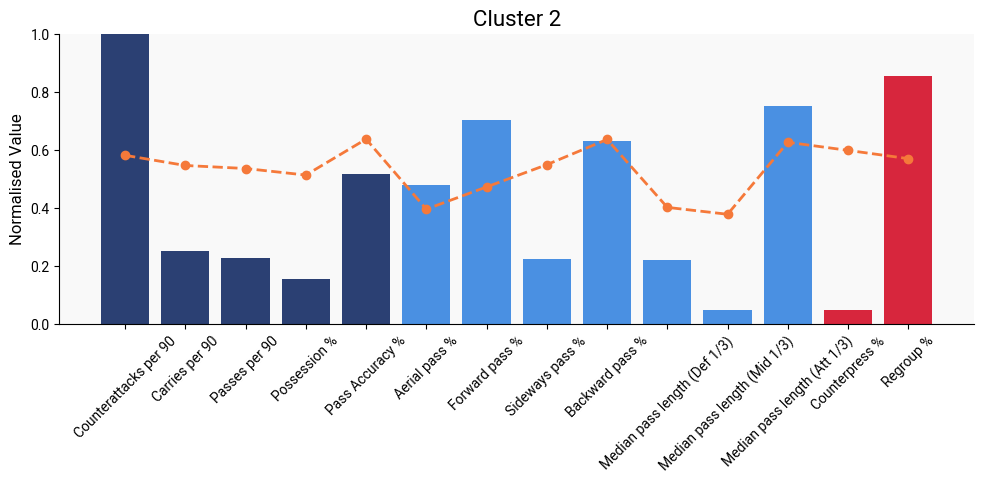

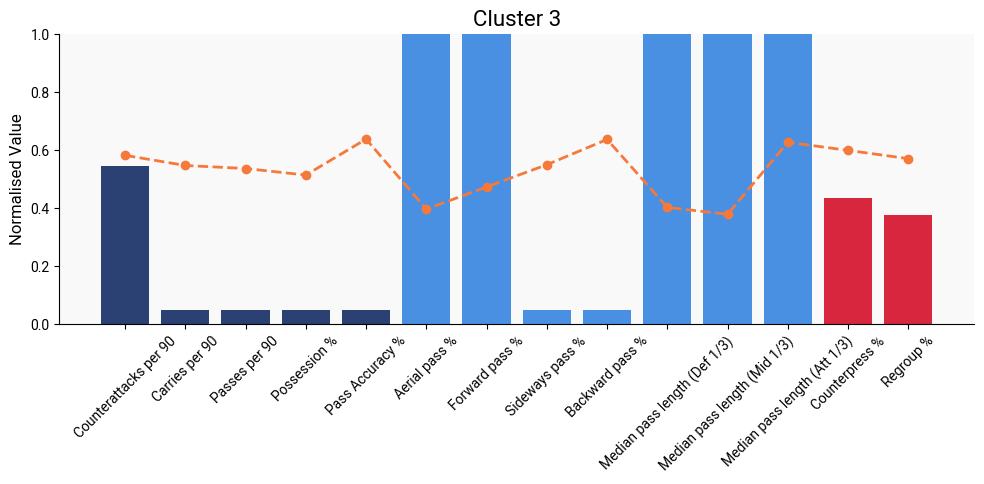

In [35]:
# ========= Sub-Cluster Event Data Charts =========

# Create DataFrame with your new hierarchical cluster data
df = pd.DataFrame({
    'cluster': [0, 1, 2, 3],
    'counterattacks_per_90': [2.90, 2.13, 3.20, 2.69],
    'carries_per_90': [462.88, 436.44, 288.79, 241.22],
    'passes_per_90': [558.03, 526.33, 371.36, 327.76],
    'possession_pct': [56.28, 53.29, 39.17, 37.02],
    'pass_accuracy_pct': [85.19, 85.01, 78.76, 72.52],
    'aerial_pass_pct': [14.79, 14.69, 21.63, 29.96],
    'forward_pass_pct': [27.48, 28.46, 34.59, 37.80],
    'sideways_pass_pct': [55.98, 55.41, 50.05, 48.70],
    'backward_pass_pct': [16.55, 16.13, 15.37, 13.51],
    'median_pass_length_def': [18.75, 20.05, 19.51, 22.98],
    'median_pass_length_mid': [15.71, 16.73, 15.68, 18.47],
    'median_pass_length_att': [13.71, 14.48, 14.53, 14.82],
    'counterpress_pct': [18.81, 19.15, 15.37, 16.90],
    'regroup_pct': [2.25, 1.12, 2.08, 1.51]
})

# Define custom colours
colours = ['#2B4073'] * 5 + ['#4a90e2'] * 7 + ['#d7263d'] * 2 

# Columns in visual order
categories = [
    'counterattacks_per_90', 'carries_per_90', 'passes_per_90', 'possession_pct', 'pass_accuracy_pct',
    'aerial_pass_pct', 'forward_pass_pct', 'sideways_pass_pct', 'backward_pass_pct',
    'median_pass_length_def', 'median_pass_length_mid', 'median_pass_length_att',
    'counterpress_pct', 'regroup_pct'
]

# Human-readable labels (optional, for x-axis)
labels = [
    "Counterattacks per 90", "Carries per 90", "Passes per 90", "Possession %", "Pass Accuracy %",
    "Aerial pass %", "Forward pass %", "Sideways pass %", "Backward pass %",
    "Median pass length (Def 1/3)", "Median pass length (Mid 1/3)", "Median pass length (Att 1/3)",
    "Counterpress %", "Regroup %"
]

# Normalise across columns and shift to avoid zero bars
df_norm = df.copy()
for col in categories:
    col_min = df[col].min()
    col_max = df[col].max()
    df_norm[col] = (df[col] - col_min) / (col_max - col_min)
    df_norm[col] = 0.05 + 0.95 * df_norm[col]  # Avoid true zero

# Plot per cluster
for i, row in df_norm.iterrows():
    fig, ax = plt.subplots(figsize=(10, 5))
    
    # Bar chart for the cluster
    bars = ax.bar(labels, row[categories], color=colours)
    
    # Plot connected average line in orange
    avg_vals = df_norm[categories].mean()
    ax.plot(labels, avg_vals, color='#f5793a', linestyle='--', linewidth=2, marker='o', zorder=5)
    
    # Axis and formatting
    ax.set_ylim(0, 1)
    ax.set_title(f"Cluster {int(row['cluster'])}", fontsize=16)
    ax.set_ylabel('Normalised Value', fontsize=12)
    ax.tick_params(axis='x', labelrotation=45)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    plt.tight_layout()
    plt.savefig(f"cluster_{int(row['cluster'])}_style_bar.png", dpi=300)
    plt.show()

In [15]:
# Create KPI data with cluster assignments
kpi_data = team_summary_avg.copy()
kpi_data['cluster'] = hierarchical_labels

# Calculate goal and xG differences
kpi_data['goal_difference'] = kpi_data['goals_per_90'] - kpi_data['goals_conceded_per_90']
kpi_data['xg_difference'] = kpi_data['xg_per_90'] - kpi_data['xga_per_90']

# Display DataFrame
kpi_display = kpi_data[['cluster', 'team', 'goals_per_90', 'xg_per_90', 'goals_conceded_per_90', 'xga_per_90', 'goal_difference', 'xg_difference']].copy()
kpi_display = kpi_display.round(2)
kpi_display = kpi_display.sort_values(['cluster', 'team']).reset_index(drop=True)
display(kpi_display)

,cluster,team,goals_per_90,xg_per_90,goals_conceded_per_90,xga_per_90,goal_difference,xg_difference
0,0,Austria,1.43,1.45,1.18,1.34,0.25,0.11
1,0,Croatia,0.61,1.82,1.88,1.21,-1.27,0.61
2,0,Denmark,0.48,0.93,0.96,1.12,-0.48,-0.19
3,0,Germany,2.08,1.60,0.48,0.73,1.60,0.87
4,0,Italy,0.71,0.78,0.96,0.98,-0.25,-0.20
5,0,Spain,1.85,1.39,0.38,0.82,1.47,0.57
6,1,Belgium,0.48,1.04,0.23,0.94,0.25,0.10
7,1,England,1.51,1.23,1.07,1.07,0.44,0.16
8,1,France,0.91,1.71,0.83,1.08,0.08,0.63
9,1,Netherlands,1.43,1.17,0.94,0.93,0.49,0.24


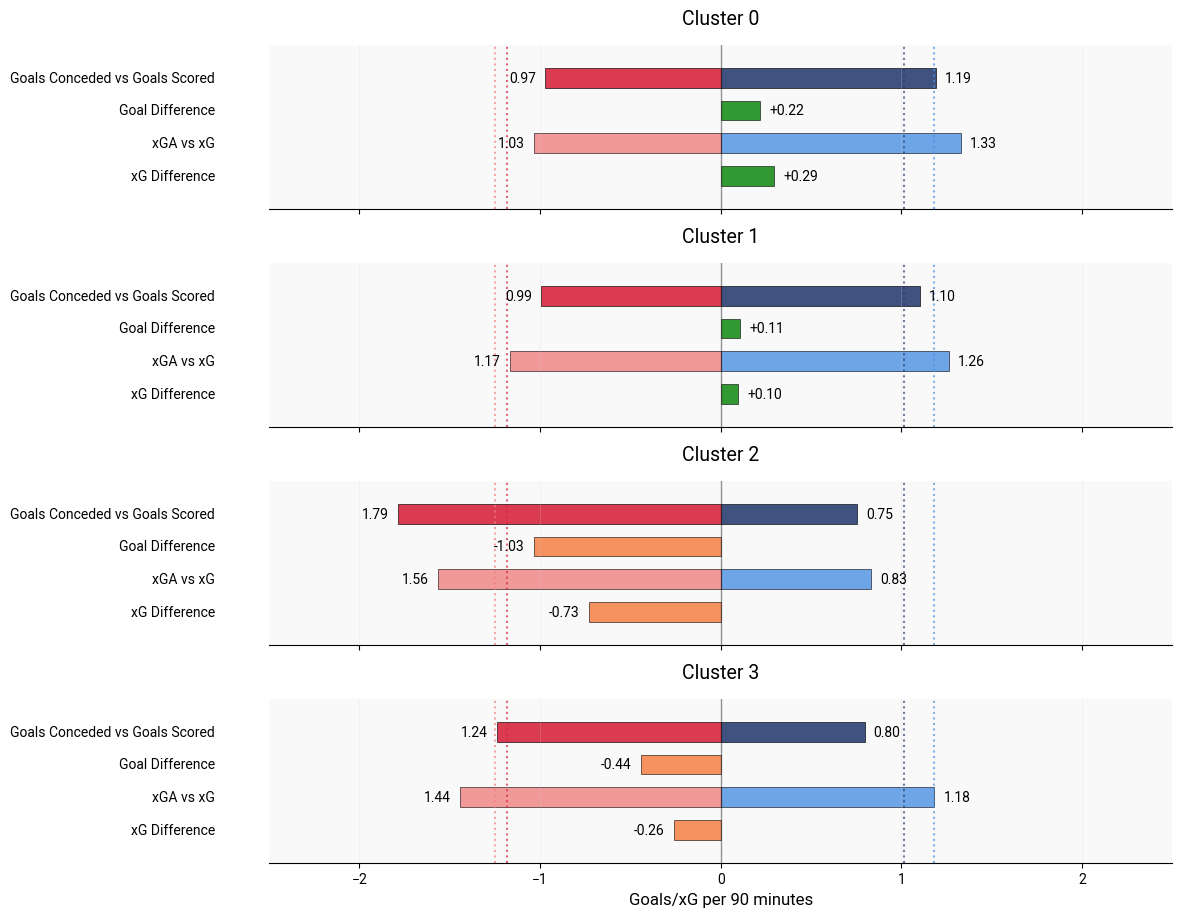

In [16]:
# ========= KPI Performance Charts =========

# First, create cluster averages and overall averages
kpi_cluster_summary = kpi_data.groupby('cluster').agg({
    'goals_per_90': 'mean',
    'goals_conceded_per_90': 'mean',
    'goal_difference': 'mean',
    'xg_per_90': 'mean',
    'xga_per_90': 'mean',
    'xg_difference': 'mean',
    'team': lambda x: list(x)  # Keep list of teams in each cluster
}).reset_index()

# Calculate overall averages for reference lines
avg_goals = kpi_data['goals_per_90'].mean()
avg_goals_conceded = kpi_data['goals_conceded_per_90'].mean()
avg_xg = kpi_data['xg_per_90'].mean()
avg_xga = kpi_data['xga_per_90'].mean()

fig, axes = plt.subplots(4, 1, figsize=(12, 10))

for i, (idx, row) in enumerate(kpi_cluster_summary.iterrows()):
    ax = axes[i]
    
    # Define the 4 rows for metrics (removed empty row)
    y_positions = [1.5, 0.5, -0.5, -1.5]  
    bar_height = 0.6
    
    # Row 1: Goals (positive) and Goals Conceded (negative) 
    ax.barh(y_positions[0], row['goals_per_90'], height=bar_height, 
            color='#2B4073', alpha=0.9, edgecolor='black', linewidth=0.5)
    ax.barh(y_positions[0], -row['goals_conceded_per_90'], height=bar_height, 
            color='#d7263d', alpha=0.9, edgecolor='black', linewidth=0.5)
    
    # Row 2: Goal Difference
    goal_diff_color = 'green' if row['goal_difference'] > 0 else '#f5793a'
    ax.barh(y_positions[1], row['goal_difference'], height=bar_height, 
            color=goal_diff_color, alpha=0.8, edgecolor='black', linewidth=0.5)
    
    # Row 3: xG (positive) and xGA (negative) 
    ax.barh(y_positions[2], row['xg_per_90'], height=bar_height, 
            color='#4a90e2', alpha=0.8, edgecolor='black', linewidth=0.5)
    ax.barh(y_positions[2], -row['xga_per_90'], height=bar_height, 
            color='lightcoral', alpha=0.8, edgecolor='black', linewidth=0.5)
    
    # Row 4: xG Difference
    xg_diff_color = 'green' if row['xg_difference'] > 0 else '#f5793a'
    ax.barh(y_positions[3], row['xg_difference'], height=bar_height, 
            color=xg_diff_color, alpha=0.8, edgecolor='black', linewidth=0.5)
    
    # Add average reference lines
    ax.axvline(x=avg_goals, color='#2B4073', linestyle=':', alpha=0.7, linewidth=1.5)
    ax.axvline(x=avg_xg, color='#4a90e2', linestyle=':', alpha=0.7, linewidth=1.5)
    ax.axvline(x=-avg_goals_conceded, color='#d7263d', linestyle=':', alpha=0.7, linewidth=1.5)
    ax.axvline(x=-avg_xga, color='lightcoral', linestyle=':', alpha=0.7, linewidth=1.5)
    ax.axvline(x=0, color='black', linestyle='-', alpha=0.4, linewidth=1)
    
    # Goals
    ax.text(row['goals_per_90'] + 0.05, y_positions[0], f'{row["goals_per_90"]:.2f}', 
            ha='left', va='center', fontproperties=roboto, fontsize=10, fontweight='bold')
    # Goals Conceded
    ax.text(-row['goals_conceded_per_90'] - 0.05, y_positions[0], f'{row["goals_conceded_per_90"]:.2f}', 
            ha='right', va='center', fontproperties=roboto, fontsize=10, fontweight='bold')
    # Goal Difference
    label_x = row['goal_difference'] + (0.05 if row['goal_difference'] >= 0 else -0.05)
    ax.text(label_x, y_positions[1], f'{row["goal_difference"]:+.2f}', 
            ha='left' if row['goal_difference'] >= 0 else 'right', va='center', 
            fontproperties=roboto, fontsize=10, fontweight='bold')
    # xG
    ax.text(row['xg_per_90'] + 0.05, y_positions[2], f'{row["xg_per_90"]:.2f}', 
            ha='left', va='center', fontproperties=roboto, fontsize=10, fontweight='bold')
    # xGA
    ax.text(-row['xga_per_90'] - 0.05, y_positions[2], f'{row["xga_per_90"]:.2f}', 
            ha='right', va='center', fontproperties=roboto, fontsize=10, fontweight='bold')
    # xG Difference
    label_x = row['xg_difference'] + (0.05 if row['xg_difference'] >= 0 else -0.05)
    ax.text(label_x, y_positions[3], f'{row["xg_difference"]:+.2f}', 
            ha='left' if row['xg_difference'] >= 0 else 'right', va='center', 
            fontproperties=roboto, fontsize=10)
    
    # Add metric labels on the left
    metric_labels = ['Goals Conceded vs Goals Scored', 'Goal Difference', 'xGA vs xG', 'xG Difference']
    for j, (y_pos, label) in enumerate(zip(y_positions, metric_labels)):
        ax.text(-2.8, y_pos, label, ha='right', va='center', 
                fontproperties=roboto, fontsize=10, fontweight='bold')
    
    # Customise subplot - Updated title format
    ax.set_title(f'Cluster {int(row["cluster"])}', 
                fontproperties=roboto, fontsize=14, fontweight='bold', pad=15)
    ax.set_xlim(-2.5, 2.5)
    ax.set_ylim(-2.5, 2.5)
    
    # Remove y-axis and ticks
    ax.set_yticks([])
    ax.spines['left'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    ax.grid(True, axis='x', alpha=0.3, linestyle='-', linewidth=0.5)
    
    # Only show x-axis label on bottom chart
    if i == len(kpi_cluster_summary) - 1:
        ax.set_xlabel('Goals/xG per 90 minutes', fontproperties=roboto, fontsize=12)
    else:
        ax.set_xticklabels([])

plt.tight_layout()
plt.subplots_adjust(top=0.88)  
plt.savefig("cluster_kpi_charts.png", dpi=300, bbox_inches='tight')
plt.show()

In [18]:
# ========= Significance Test =========

from scipy.stats import kruskal
import pandas as pd

data = {
    'cluster': [0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 3, 3, 3],
    'team': ['Austria', 'Croatia', 'Denmark', 'Germany', 'Italy', 'Spain',
             'Belgium', 'England', 'France', 'Netherlands', 'Portugal', 'Serbia', 
             'Slovakia', 'Switzerland', 'Turkey', 'Ukraine',
             'Albania', 'Georgia', 'Hungary', 'Poland', 'Scotland',
             'Czech Republic', 'Romania', 'Slovenia'],
    'goals_per_90': [1.43, 0.61, 0.48, 2.08, 0.71, 1.85, 0.48, 1.51, 0.91, 1.43, 1.44, 0.32, 0.9, 1.91, 1.5, 0.63, 0.93, 0.95, 0.61, 0.96, 0.32, 0.95, 0.96, 0.48],
    'xg_per_90': [1.45, 1.82, 0.93, 1.6, 0.78, 1.39, 1.04, 1.23, 1.71, 1.17, 2.41, 0.65, 0.83, 1.41, 1.22, 0.95, 0.68, 1, 1.04, 1.13, 0.32, 1.45, 0.9, 1.2],
    'goals_conceded_per_90': [1.18, 1.88, 0.96, 0.48, 0.96, 0.38, 0.23, 1.07, 0.83, 0.94, 1.29, 0.64, 1.1, 1.43, 1.14, 1.27, 1.27, 1.91, 1.59, 1.92, 2.25, 1.26, 1.44, 1.02],
    'xga_per_90': [1.34, 1.21, 1.12, 0.73, 0.98, 0.82, 0.94, 1.07, 1.08, 0.93, 1.63, 0.85, 1.39, 1.43, 1.53, 0.8, 1.34, 2.48, 1.19, 1.6, 1.21, 1.34, 1.36, 1.63]
}

df = pd.DataFrame(data)

# Variables to test
variables = ['goals_per_90', 'xg_per_90', 'goals_conceded_per_90', 'xga_per_90']

# Run Kruskal-Wallis tests
kw_results = {}
for var in variables:
    # Get data for each cluster
    cluster_groups = [df[df['cluster'] == i][var].values for i in range(4)]
    
    # Kruskal-Wallis test
    h_stat, p_val = kruskal(*cluster_groups)
    
    # Store results
    kw_results[var] = {'H_statistic': h_stat, 'p_value': p_val, 'significant': p_val < 0.05}
    
    print(f"{var}:")
    print(f"  H(3) = {h_stat:.3f}, p = {p_val:.3f}")
    if p_val < 0.05:
        print(f"  ✓ SIGNIFICANT difference between clusters")
    else:
        print(f"  ✗ No significant difference between clusters")
    print()

# Summary
significant_vars = [var for var, result in kw_results.items() if result['significant']]

if significant_vars:
    print(f"Variables with significant differences: {', '.join(significant_vars)}")
    for var in significant_vars:
        h_stat = kw_results[var]['H_statistic']
        p_val = kw_results[var]['p_value']
        print(f"  {var}: H(3) = {h_stat:.3f}, p = {p_val:.3f}")
else:
    print("No variables showed significant differences between clusters.")
    print("This suggests that while tactical styles differ, performance outcomes are similar.")

KRUSKAL-WALLIS TEST RESULTS
Cluster sizes: {0: 6, 1: 10, 2: 5, 3: 3}

goals_per_90:
  H(3) = 1.282, p = 0.733
  ✗ No significant difference between clusters

xg_per_90:
  H(3) = 3.998, p = 0.262
  ✗ No significant difference between clusters

goals_conceded_per_90:
  H(3) = 9.970, p = 0.019
  ✓ SIGNIFICANT difference between clusters

xga_per_90:
  H(3) = 6.312, p = 0.097
  ✗ No significant difference between clusters

SUMMARY:
--------------------
Variables with significant differences: goals_conceded_per_90
  goals_conceded_per_90: H(3) = 9.970, p = 0.019
